In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import random
import seaborn as sns
from scipy.stats import skew, kurtosis, gaussian_kde
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

random.seed(8)
%matplotlib inline
sns.set()

breast_cancer = load_breast_cancer()
print(breast_cancer.data.shape)

(569, 30)


In [2]:
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

def sklearn_data_to_pandas_df(sklearn_data):
    """ Converts sklearn datasets to a pandas df.
    """
    cols = list(sklearn_data['feature_names']) + ['target']
    dataframe = pd.DataFrame(data= np.c_[sklearn_data['data'], sklearn_data['target']], columns= cols)
    return dataframe


class ExploratoryDataAnalysis(object):                              
    """Explore a pandas dataframe using plots and summaries.

    Attributes:
        dataframe: A Pandas dataframe representation of the data set.
    """
    
    def __init__(self, dataframe):
        self.df = dataframe
        
    def create_numeric_df(self):
        return df.select_dtypes(include=[np.number])

    def create_non_numeric_df(self):
        return df.select_dtypes(exclude=[np.number])
    
    def calc_coefficient_of_variation(self, df_description):
        """Calculates the coefficient of variation
        for each variable in a dataframe produced
        by df.describe()

        Args:
            df_description: A pandas df built from df.describe

        Returns:
            A pandas df in the format of df.describe but with 
            the coef of var included as an additional row.
        """
        coef_variation = df_description.loc["std"] / df_description.loc["mean"]
        df_description.loc["coef_var"] = coef_variation
        return df_description.sort_values(by="coef_var", axis=1)

    def describe_numeric_data(self):
        """Produces a df of summary stats for the numeric
        columns in a df in the style of df.describe() but 
        the coefficient of variation is included as well.
        """
        df_description = self.df.describe(include=[np.number])
        return self.calc_coefficient_of_variation(df_description)

    def describe_non_numeric_data(self):
        """Produces a df of summary stats for the non-numeric
        columns in a df in the style of df.describe().
        """
        return self.df.describe(exclude=[np.number])

    def plot_coef_of_variation(self, cutoff=0):
        """Creates a plot of the numeric variables in a pandas df
        that have the largest coefficient of variation.

        Args:
            df: A pandas dataframe
            cutoff: A float. Any value for the coefficient of 
                variation that is larger than the cutoff
                will be included in the plot.
            Returns: A seaborn barplot of the coef of variation
                plotted in order of largest to smallest."""
        df_num_description = self.describe_numeric_data()
        df_coef_var = df_num_description.loc[['coef_var']][df_num_description > cutoff]
        df_coef_var = df_coef_var.dropna(axis=1).transpose().sort_values('coef_var',ascending=False)
        df_coef_var['numeric_vars'] = df_coef_var.index
        plot_coef_var = sns.barplot(x="numeric_vars", y="coef_var", data=df_coef_var, color='lightslategrey')
        plot_coef_var = plt.setp(plot_coef_var.get_xticklabels(), rotation=80)
        return plot_coef_var[1]

    def _offset(self, key, key_range, value, max_value):
        return (key - key_range * 0.0125, value + max_value * 0.01)

    def counter_histogram(self, labels):
        """Produces a histogram from a list or pandas 
        series with the counts of each category 
        printed above the bar.

        Args:
            labels: A pandas series or list. The values
                inside will be tallied to create the histogram.
        """
        counts = Counter(labels)
        fig, ax = plt.subplots()
        int_keys = [int(k) for k in counts.keys()]
        ax.bar(int_keys, list(counts.values()), color=bar_color)
        ax.set_xticks(sorted(int_keys))

        k_range = max(counts.keys()) - min(counts.keys())
        max_v = max(counts.values())

        for (k, v) in counts.items():
            ax.annotate(str(v), self._offset(k, k_range, v, max_v))
            
    
    def get_top_abs_correlations(self, numeric_cols, n=5):
        """Get the variable combinations that yeild the
        highest absolute correlation.

        Args:
            numeric_cols: A list of strings representing
            the names of numeric columns in the dataframe.
            n: An integer representing how many of the top 
                variable combinations to return.
        """
        df_corr = self.df[numeric_cols].corr()
        df_top_corr = (df_corr.abs()
              .where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
              .stack()
              .sort_values(ascending=False))
        return df_top_corr[:n]

    def pair_plot(self, save=False, **kwargs):
        """Extend seaborn's pair_plot function with the option
        to save the plot to an external PDF.
        """
        pair_plot = sns.pairplot(self.df, **kwargs)

        if save:
            pp = PdfPages('pair_plot.pdf')
            pp.savefig(pair_plot.fig,  bbox_inches='tight')
            pp.close()
            
    def numeric_cols_distribution_plot(self, numeric_cols, **kwargs):
        """Display the distribution of each numeric variable
        in the dataframe.
        
        Args:
            numeric_cols: A list of strings representing
            the names of numeric columns in the dataframe.
        """
        for i, col in enumerate(numeric_cols):
            plt.figure(i)
            sns.distplot(self.df[numeric_cols][col], kde=False, **kwargs)
    
    def corr_heatmap(self, numeric_cols, **kwargs):
        """Display a heatmap of the correlation matrix
        computed on the numeric columns of a dataframe.
        
        Args:
            numeric_cols: A list of strings representing
            the names of numeric columns in the dataframe.
        """
        df_corr = self.df[numeric_cols].corr()
        sns.heatmap(df_corr, cmap='viridis', **kwargs)
        
class ClusteringEDA(object):
    """Explore a pandas dataframe by clustering.

    Attributes:
        standardized_dataframe: A standardized (centered/scaled) 
            Pandas dataframe representation of the data set.
        X_numeric_columns: A list of strings representing the 
            numeric type independent variables. These variables
            will be used to carry out the unsupervised clustering.
        y: A string representing the name of the response variable.
    """
    def __init__(self, standardized_dataframe, X_numeric_columns, y):
        self.df = standardized_dataframe
        self.X_numeric = X_numeric_columns
        self.y = y
        
    def cluster_histogram(self, num_clusters=8):
        #fit = DBSCAN(min_samples=15).fit(self.df[X_numeric])
        fit = SpectralClustering(n_clusters = num_clusters).fit(self.df[self.X_numeric])
        base_sample_clusters = pd.Series(fit.labels_, index=self.df.index)
        ExploratoryDataAnalysis(self.df).counter_histogram(base_sample_clusters)
        
    def plot_clusters_2d(self):
        X_tsne = TSNE(n_components=2, learning_rate=100).fit_transform(self.df[self.X_numeric])
        X_pca = PCA(n_components=2).fit_transform(self.df[self.X_numeric])

        df_manifold = pd.DataFrame({'tsne_0':X_tsne[:, 0], 
                                    'tsne_1':X_tsne[:, 1], 
                                    'pca_0': X_pca[:, 0], 
                                    'pca_1': X_pca[:, 1], 
                                    y: df[self.y]})

        sns.lmplot("tsne_0", "tsne_1", data=df_manifold, hue=y, fit_reg=False, markers=["o", "x"])
        sns.lmplot("pca_0", "pca_1", data=df_manifold, hue=y, fit_reg=False, markers=["o", "x"])

    
    def plot_clusters_3d(self):
        fig = plt.figure()
        ax = Axes3D(fig)

        X_tsne_3d = TSNE(n_components=3, learning_rate=100).fit_transform(self.df[self.X_numeric])
        ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=self.df[self.y], cmap=plt.cm.RdYlGn)
        plt.show()


In [3]:
df = sklearn_data_to_pandas_df(breast_cancer)
df['diagnosis'] = np.where(df['target']==0, 'malignant', 'benign')
df['large mean concavity'] = np.where(df['mean concavity']>df['mean concavity'].median(), 'large', 'small')

df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis,large mean concavity
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0,malignant,large
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0,malignant,large
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0,malignant,large
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0,malignant,large
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0,malignant,large


In [4]:
df['mean concavity'].median()

0.06154

In [5]:
df = df.sample(n=300)

numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
non_num_cols = list(df.select_dtypes(exclude=[np.number]).columns)
y = 'target'
exclusions = [y, 'diagnosis']
X = [col for col in df.columns if col not in exclusions]
X_numeric = [col for col in numeric_cols if col not in exclusions]

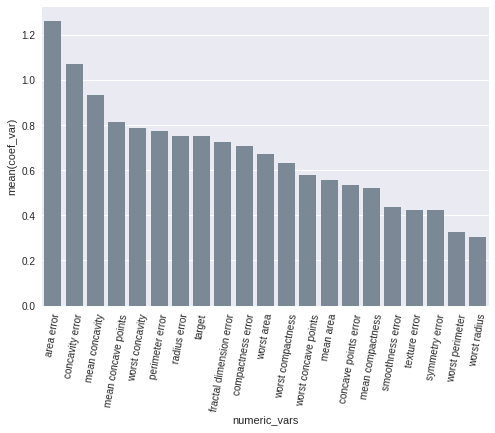

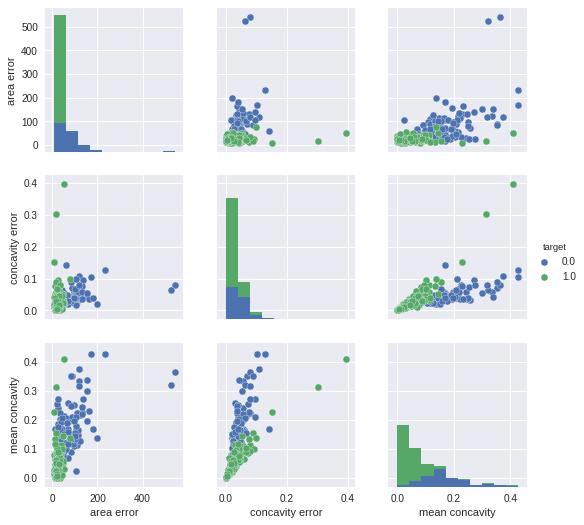

In [6]:
eda = ExploratoryDataAnalysis(df)

eda.describe_numeric_data()
plot_coef_var = eda.plot_coef_of_variation(cutoff=0.3)
eda.pair_plot(vars=['area error', 'concavity error', 'mean concavity'], hue=y)


/home/edward/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


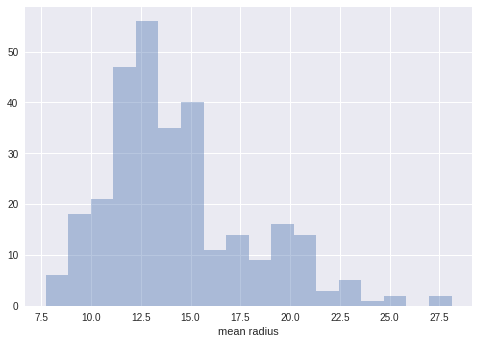

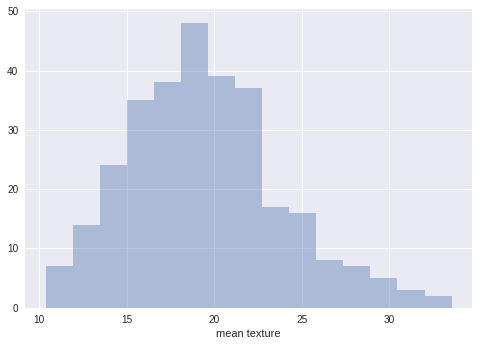

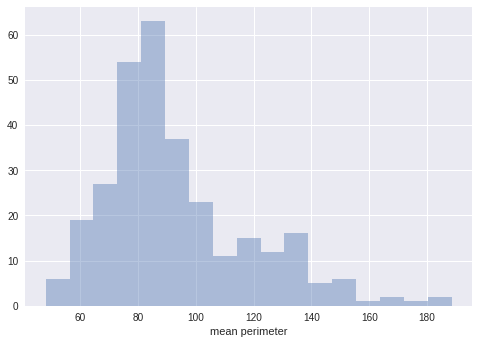

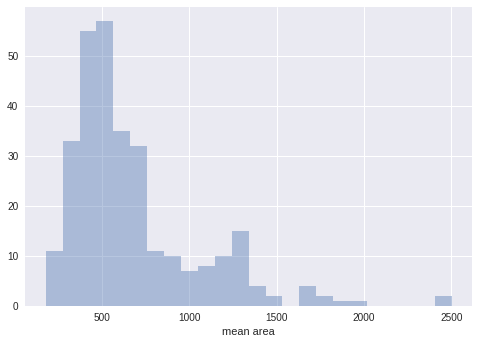

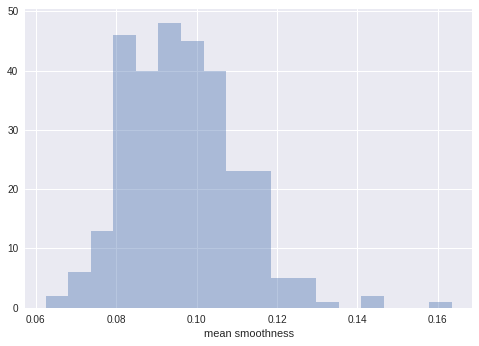

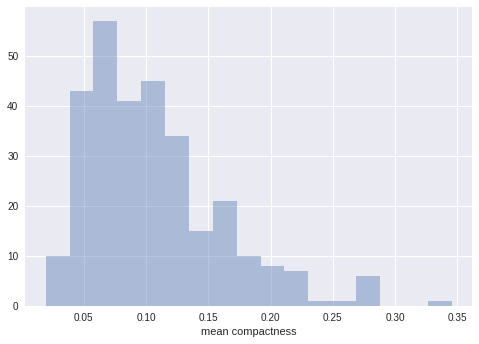

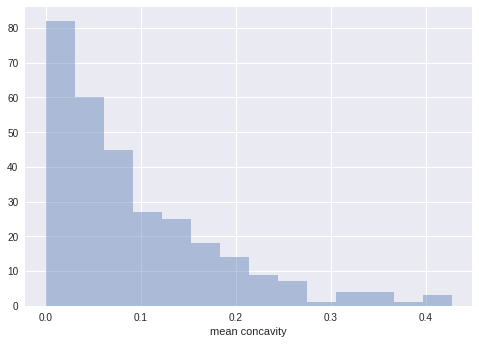

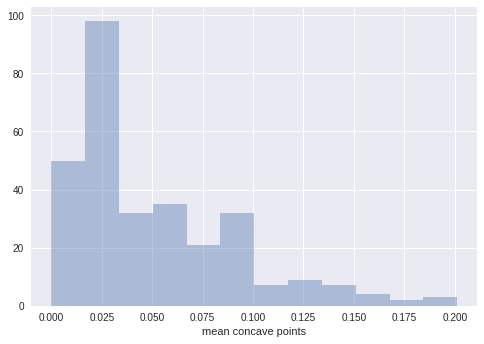

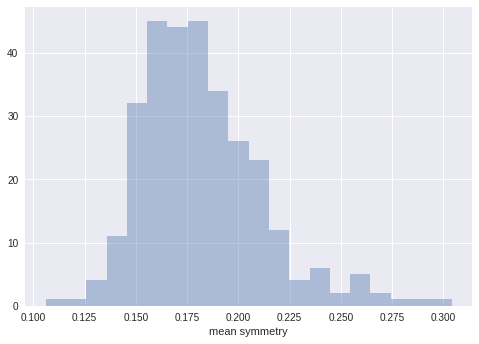

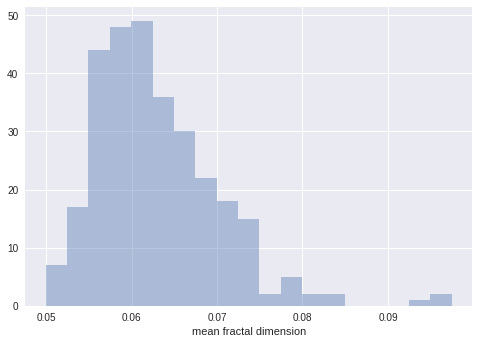

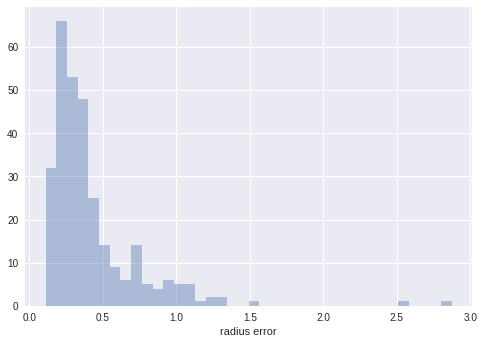

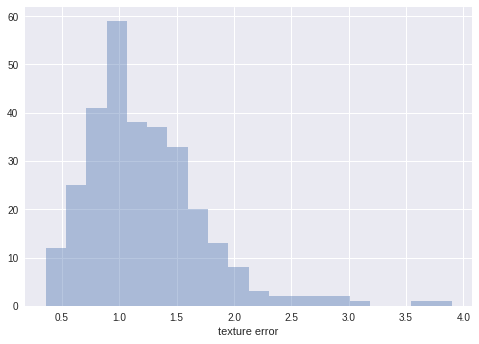

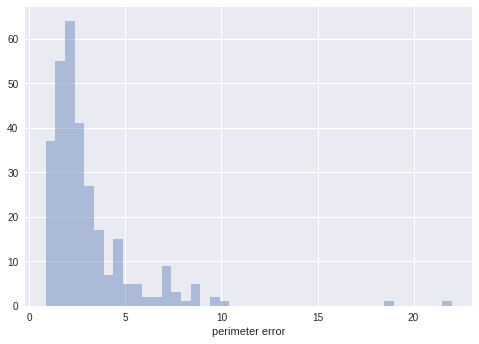

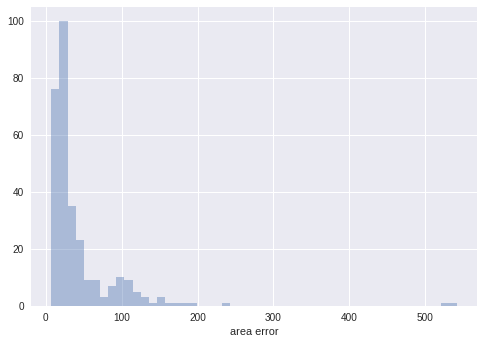

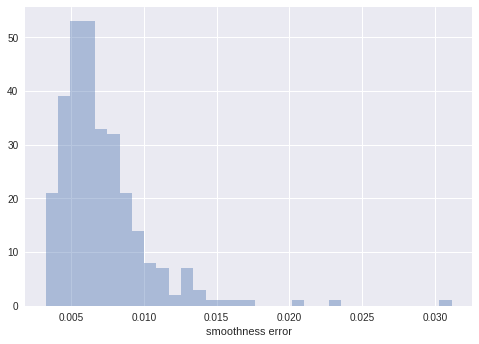

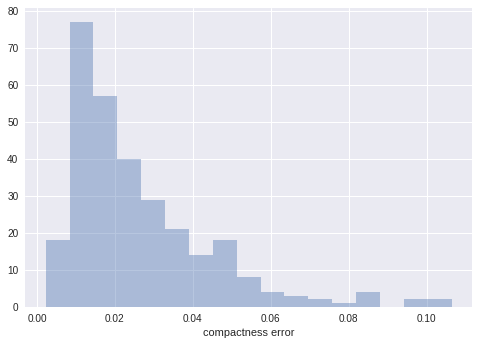

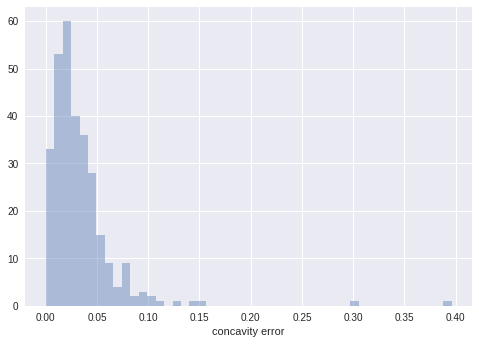

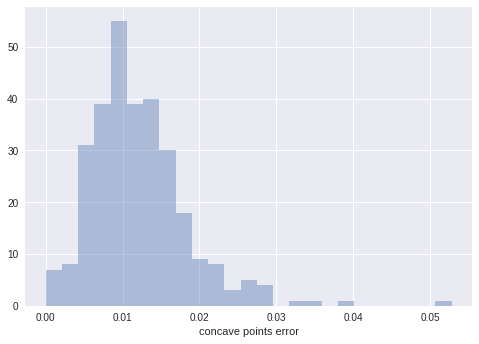

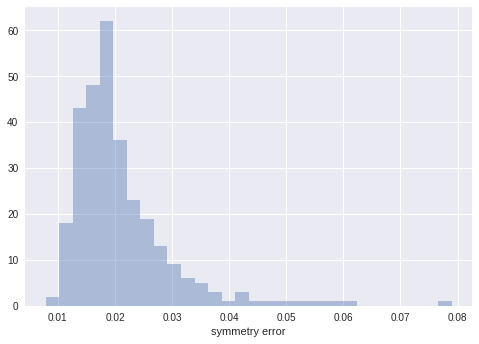

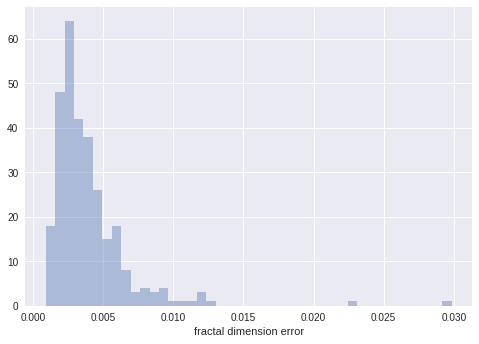

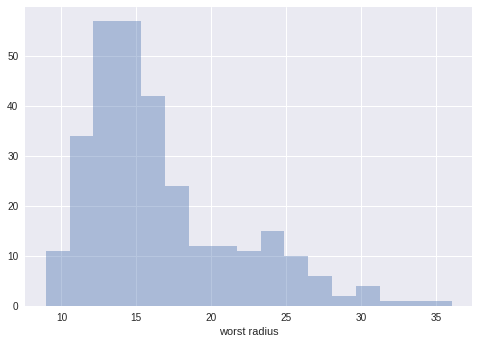

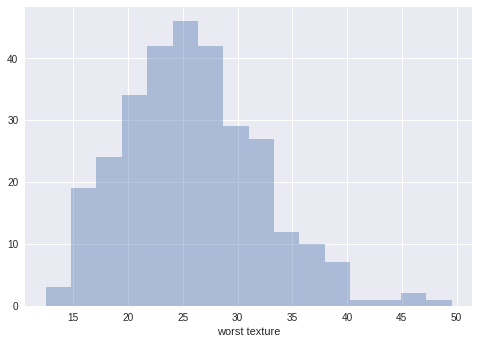

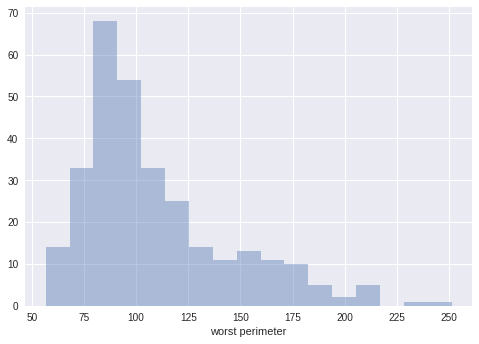

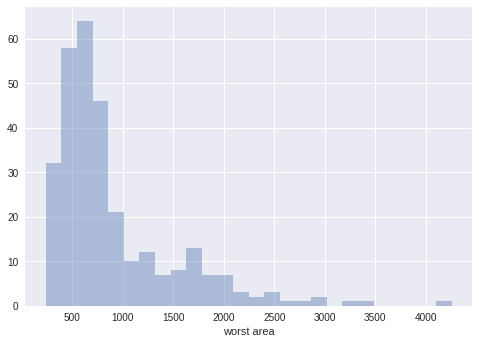

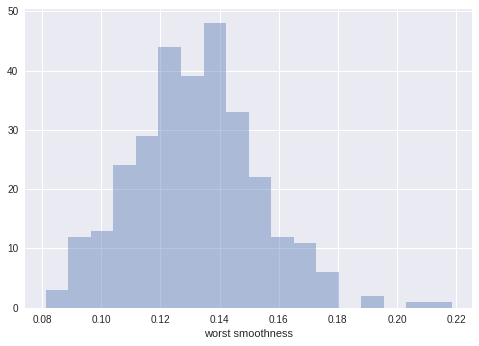

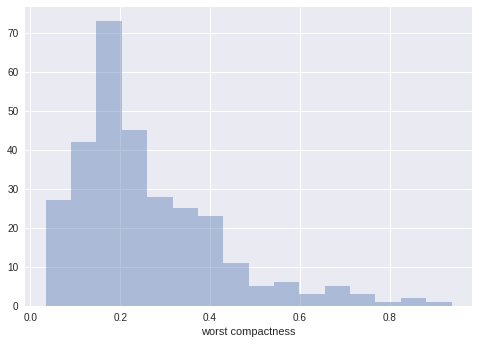

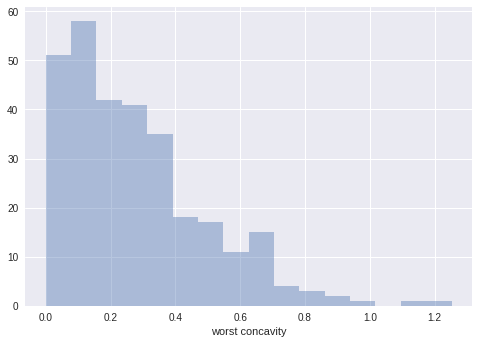

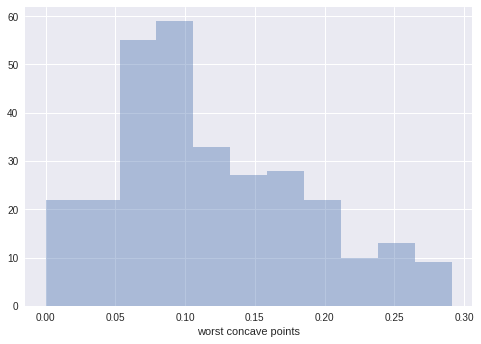

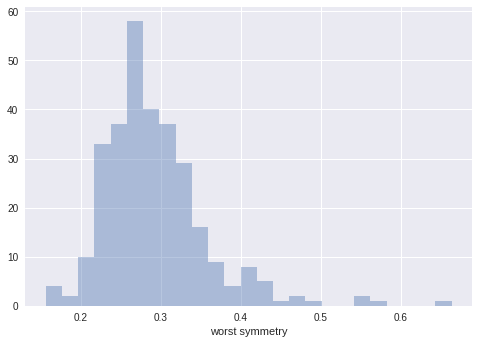

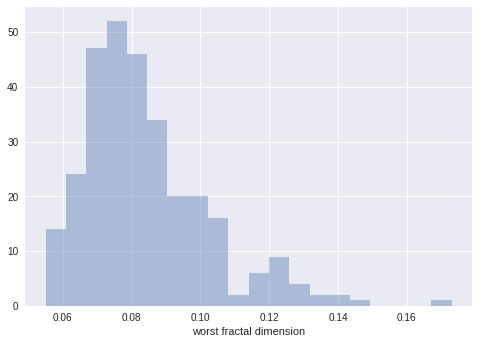

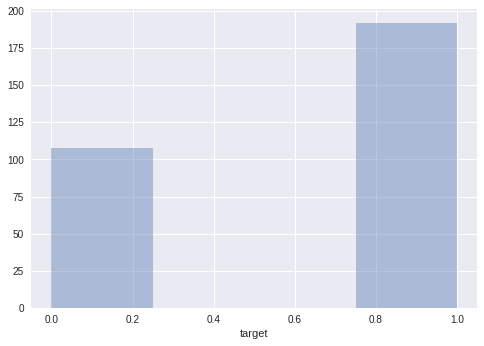

In [7]:
eda.numeric_cols_distribution_plot(numeric_cols)

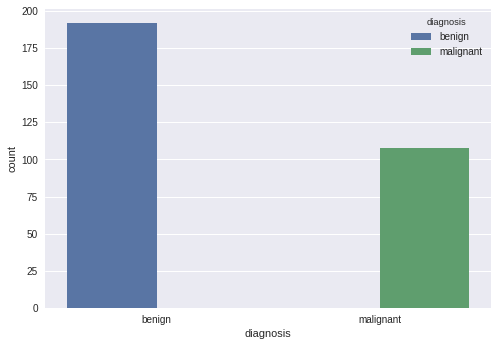

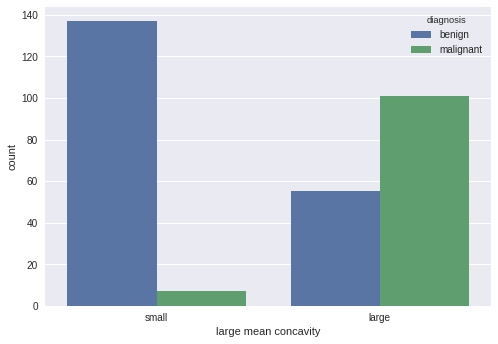

In [8]:
for i, col in enumerate(non_num_cols):
    plt.figure(i)
    sns.countplot(x=col, data=df[non_num_cols], hue='diagnosis')

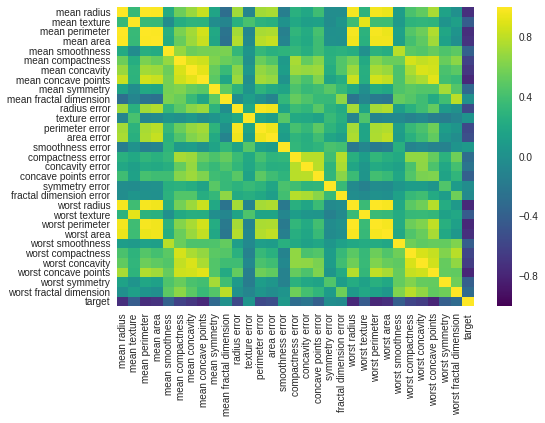

In [9]:
eda.corr_heatmap(numeric_cols)

In [10]:
eda.get_top_abs_correlations(numeric_cols)

mean radius     mean perimeter     0.997965
worst radius    worst perimeter    0.993406
mean radius     mean area          0.986629
mean perimeter  mean area          0.986095
worst radius    worst area         0.983382
dtype: float64

## Identifying structure through unsupervised learning
* In addition to looking for deviations, it is important to identify the latent structure in the data. 
* Hierarchical clustering algorithms are good because you don't need to specify a cluster count. 

* Hierarchical clustering algorithms also gives your variables a partial order, which you can take advantage of. 
* My preferred form of clustering is a technique called HDBSCAN.
* It takes the minimum cluster size as the only parameter, and it produces both discrete and hierarchical clustering.
* Ideally the clustering will not have a single cluster that holds many obs.

In [11]:
bar_color = "cornflowerblue"
df_standardized = pd.DataFrame(StandardScaler().fit_transform(df[numeric_cols]),
                               columns=numeric_cols,
                               index=df[numeric_cols].index)

cluster_eda = ClusteringEDA(df_standardized, X_numeric, y)


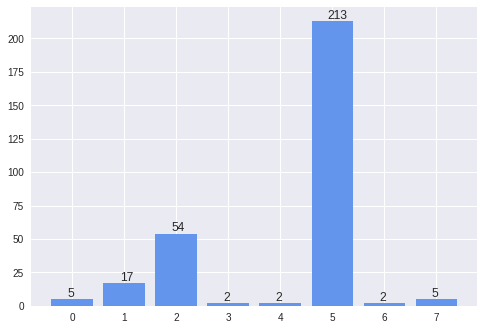

In [12]:
#df_standardized.describe()
cluster_eda.cluster_histogram()

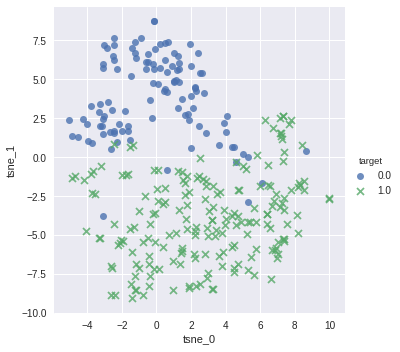

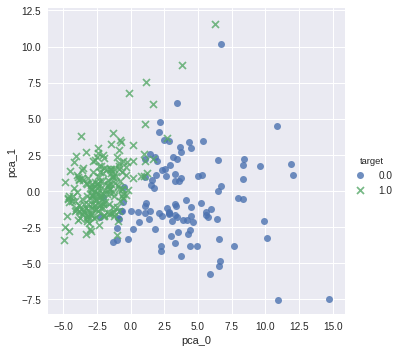

In [13]:
%matplotlib inline
cluster_eda.plot_clusters_2d()

<IPython.core.display.Javascript object>


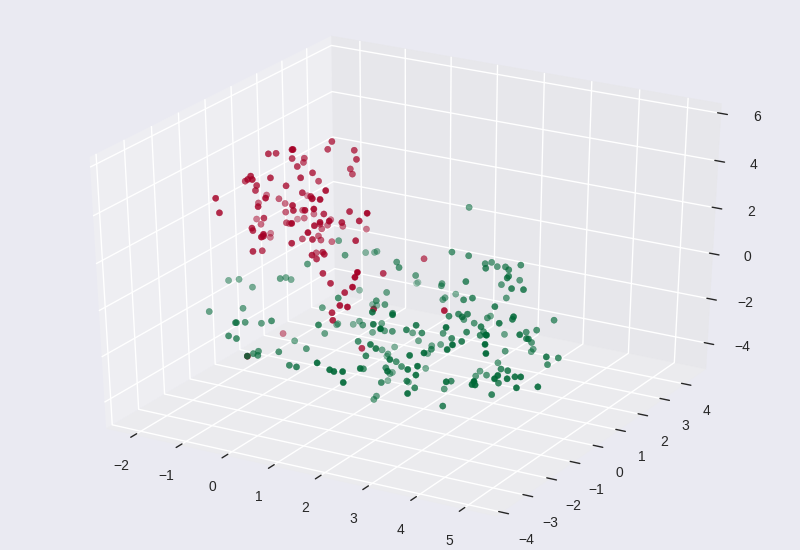

In [15]:
%matplotlib notebook
cluster_eda.plot_clusters_3d()